<a href="https://colab.research.google.com/github/feliperecker/MVP/blob/main/Maternal_Health_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevenção de Riscos à Saúde em Gestantes com Machine Learning

### Felipe Coelho Recker Rabello

## Definição do Problema

### Descrição do Problema

Objetivo: Desenvolver um modelo de machine learning para classificar o nível de risco de saúde em gestantes, a partir de atributos relacionados à saúde (como pressão arterial, nível de glicose, temperatura corporal e frequência cardíaca). Este modelo pode auxiliar profissionais de saúde a identificar gestantes com risco elevado e priorizar cuidados preventivos.

Motivação: Identificar precocemente gestantes em risco pode melhorar o planejamento dos cuidados e potencialmente reduzir complicações graves para mães e bebês.

---



### Premissas e Hipóteses

Premissas: Os dados coletados são representativos da população de gestantes e refletem bem as condições de saúde materna.
As variáveis, como pressão arterial, glicose, temperatura corporal e frequência cardíaca, estão adequadamente relacionadas ao risco de saúde materna.

Hipóteses: Existe uma correlação significativa entre os indicadores de saúde (como níveis de pressão arterial e glicose) e o nível de risco de saúde materna.
O modelo poderá aprender a distinguir diferentes níveis de risco (como "baixo", "médio" e "alto") com base nesses indicadores de saúde.

---



### Condições para Seleção dos Dados

Somente gestantes cujos dados de saúde (idade, pressão arterial, glicose, temperatura corporal e frequência cardíaca) estejam completos e disponíveis para análise.

---



### Descrição do Dataset

Atributos:
*   Idade: Idade da gestante.
*   SystolicBP: Pressão arterial sistólica.
*   DiastolicBP: Pressão arterial diastólica.
*   BS (Blood Sugar): Nível de glicose no sangue.
*   BodyTemp: Temperatura corporal.
*   HeartRate: Frequência cardíaca.
*   RiskLevel: Nível de risco de saúde materna (ex.: "baixo", "médio", "alto").


Anotações: Cada entrada inclui o nível de risco atribuído, que será a variável alvo do modelo de classificação.

Características: Dados tabulares com variáveis numéricas contínuas e categóricas (nível de risco).

---



## **Configuração Inicial e Carregamento do Dataset**

### Importação de Bibliotecas

Este código importa as bibliotecas e classes necessárias para o desenvolvimento do modelo de machine learning.

In [4]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # padronização dos dados
from sklearn.preprocessing import MinMaxScaler # padronização dos dados
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # para executar a estratificação
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para otimização dos hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV # para otimização dos hiperparâmetros RF
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.pipeline import Pipeline # para executar o pipeline
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.ensemble import BaggingClassifier # algoritmo ensemble Bagging
from sklearn.ensemble import RandomForestClassifier # algoritmo ensemble Random Forest
from sklearn.ensemble import ExtraTreesClassifier # algoritmo ensemble Árvores Extras
from sklearn.ensemble import VotingClassifier # algoritmo ensemble Voting
from sklearn.ensemble import GradientBoostingClassifier # algoritmo ensemble GradientBoosting

### Carga do Dataset

Este código carrega o dataset de risco de saúde materna diretamente de uma URL e exibe uma amostra inicial para inspeção.

In [5]:
# Informa a URL de importação do dataset
dataset = "https://raw.githubusercontent.com/feliperecker/MVP/refs/heads/main/Dataset.csv"

# Lê o arquivo
dataset = pd.read_csv(dataset, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## **Preparação dos Dados**

### Descrição

#### Separação do Conjunto de Dados

Divide o dataset em variáveis independentes (X) e dependentes (Y). A variável y representa o nível de risco de saúde materna.

---

#### Divisão em Conjuntos de Treino e Teste

Utiliza `train_test_split` para separar os dados em treino (80%) e teste (20%), com estratificação para garantir que a proporção de classes seja mantida nos conjuntos de treino e teste. O parâmetro `random_state` assegura reprodutibilidade dos resultados.

---



#### Configuração da Validação Cruzada

É utilizada a validação cruzada estratificada (`StratifiedKFold`) para garantir que cada partição na validação mantenha a proporção das classes de risco. A validação cruzada ajuda a verificar a robustez do modelo em diferentes divisões do dataset, o que é importante para evitar overfitting e garantir um bom desempenho generalizado.

---



### Preparação e Particionamento dos Dados para Treinamento e Validação

Este código prepara o dataset para o treinamento e avaliação do modelo, incluindo a separação dos dados e a configuração da validação cruzada.

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:6]
y = array[:,6]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10 # Número de partições para a validação cruzada
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## **Modelagem e Inferência**

### Descrição

#### Seleção dos Algoritmos

Foram selecionados algoritmos que lidam bem com dados tabulares e de classificação, incluindo classificadores básicos (KNN, Árvore de Decisão, Naive Bayes, SVM) e ensemble (Random Forest, Extra Trees, Gradient Boosting, Bagging e Voting). A escolha foi baseada na flexibilidade desses algoritmos para ajustar hiperparâmetros e pela capacidade dos ensembles de capturar padrões complexos, tornando-os ideais para aumentar a generalização e a robustez do modelo.

---



#### Ajuste Inicial dos Hiperparâmetros

Parâmetros iniciais, como o número de árvores (`num_trees`) e o número máximo de features (`max_features`), foram definidos para Random Forest e Bagging. Essas configurações ajudam a equilibrar a complexidade do modelo e a eficiência computacional. Além disso, foram construídos pipelines para incluir transformações de pré-processamento com `StandardScaler` e `MinMaxScaler`, ajustando os dados para algoritmos que se beneficiam de inputs em uma escala uniforme.

---



#### Treinamento dos Modelos e Verificação de Underfitting

Cada modelo foi treinado com validação cruzada estratificada usando 10 partições, o que ajuda a identificar potenciais problemas de underfitting. O uso de múltiplos algoritmos, permite observar variações no desempenho e ajuda a evitar underfitting, especialmente em modelos básicos, comparados aos ensembles que geralmente oferecem melhor generalização.

---



#### Otimização de Hiperparâmetros

Foi realizada a otimização dos hiperparâmetros do modelo K-Nearest Neighbors (KNN), ajustando o número de vizinhos (`n_neighbors`), a métrica de distância (`metric`) e o peso das amostras (`weights`) usando `GridSearchCV`. Esse ajuste visa melhorar a acurácia e a robustez do modelo, maximizando o desempenho nos dados originais, padronizados e normalizados. A abordagem automatizada evita a seleção manual de parâmetros, explorando combinações ideais que melhor capturam a estrutura dos dados para o KNN.

---



#### Uso de Métodos Avançados e Comitê de Modelos (Ensembles)

Foram implementados métodos de ensemble, como Random Forest, Extra Trees, Bagging e Voting, para aumentar a robustez e estabilidade do modelo ao combinar previsões de diferentes classificadores. Também foi criado um comitê de modelos (VotingClassifier) que agrega previsões de KNN, Árvore de Decisão e Naive Bayes, para melhorar a acurácia e a generalização.

---



### Criação e Avaliação de modelos de Classificação
Este código define, avalia e compara modelos de classificação e métodos ensemble para análise de desempenho. Cada modelo é avaliado usando validação cruzada, com os resultados de acurácia média e desvio padrão. Em seguida, um boxplot mostra visualmente a distribuição das acurácias, facilitando a comparação entre os modelos e auxiliando na seleção do classificador mais adequado para o problema.

KNN: 0.699187 (0.023439)
CART: 0.823653 (0.020855)
NB: 0.622689 (0.033635)
SVM: 0.570912 (0.038395)
RF: 0.831090 (0.023312)
ET: 0.826152 (0.020879)
GB: 0.789220 (0.035425)
Bagging: 0.836043 (0.017925)
Voting: 0.784237 (0.032159)


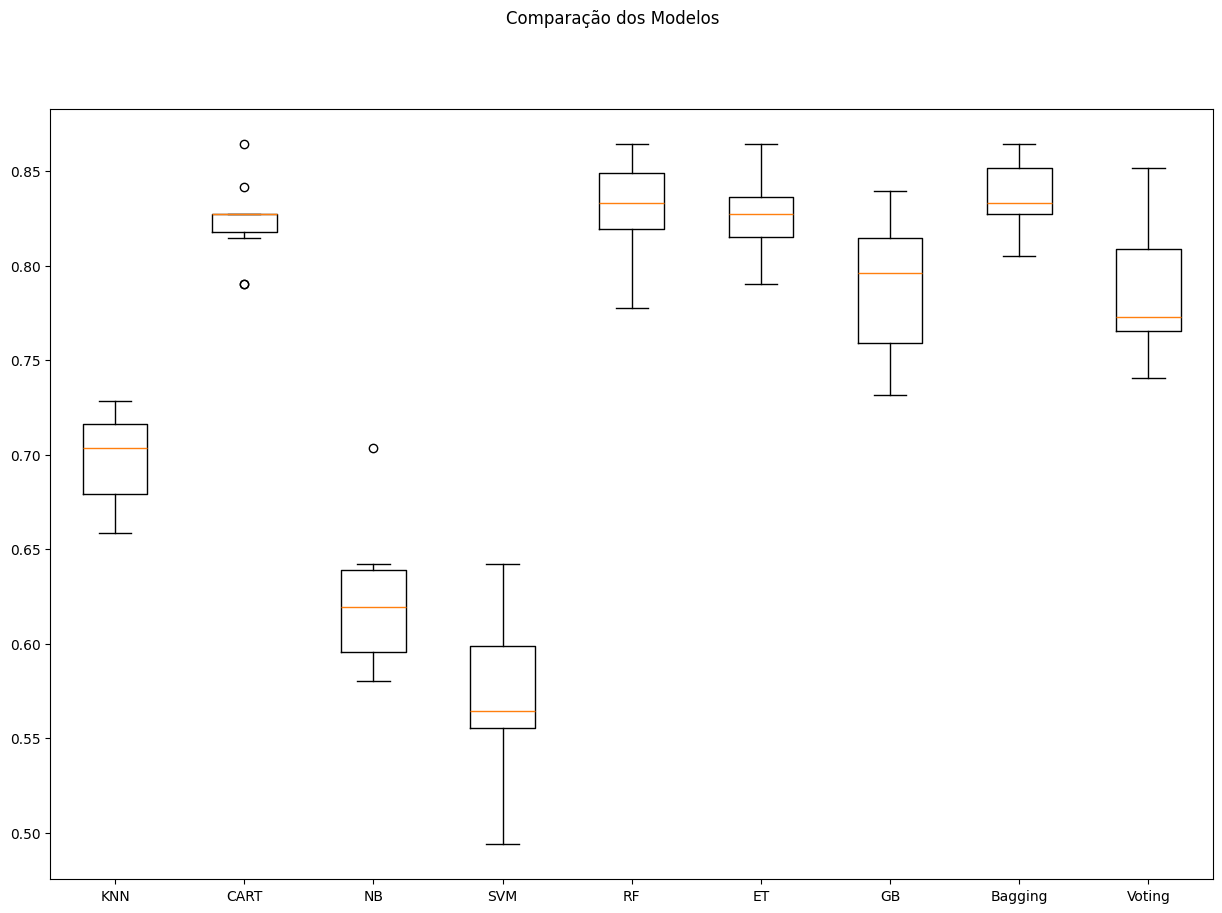

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = KNeighborsClassifier()
bases.append(('knn', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = GaussianNB()
bases.append(('nb', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Bagging', BaggingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e Avaliação de Modelos: Dados Padronizados e Normalizados

Este código configura pipelines de classificação com três versões do dataset: original, padronizado e normalizado. Ele combina os algoritmos com os diferentes pré-processamentos (`StandardScaler` para padronização e `MinMaxScaler` para normalização). Cada pipeline é avaliado usando validação cruzada, com a média e o desvio padrão da acurácia para cada combinação. Por fim, um boxplot visualiza o desempenho dos modelos, facilitando a comparação entre algoritmos e métodos de pré-processamento

KNN-orig: 0.699 (0.023)
CART-orig: 0.824 (0.021)
NB-orig: 0.623 (0.034)
SVM-orig: 0.571 (0.038)
Bag-orig: 0.834 (0.017)
RF-orig: 0.826 (0.019)
ET-orig: 0.826 (0.020)
GB-orig: 0.789 (0.035)
Vot-orig: 0.784 (0.032)
KNN-padr: 0.699 (0.038)
CART-padr: 0.815 (0.023)
NB-padr: 0.623 (0.034)
SVM-padr: 0.708 (0.044)
Bag-padr: 0.831 (0.017)
RF-padr: 0.824 (0.020)
ET-padr: 0.826 (0.018)
GB-padr: 0.789 (0.035)
Vot-padr: 0.761 (0.040)
KNN-norm: 0.714 (0.043)
CART-norm: 0.822 (0.023)
NB-norm: 0.623 (0.034)
SVM-norm: 0.693 (0.046)
Bag-norm: 0.830 (0.015)
RF-norm: 0.837 (0.022)
ET-norm: 0.825 (0.020)
GB-norm: 0.789 (0.035)
Vot-norm: 0.776 (0.052)


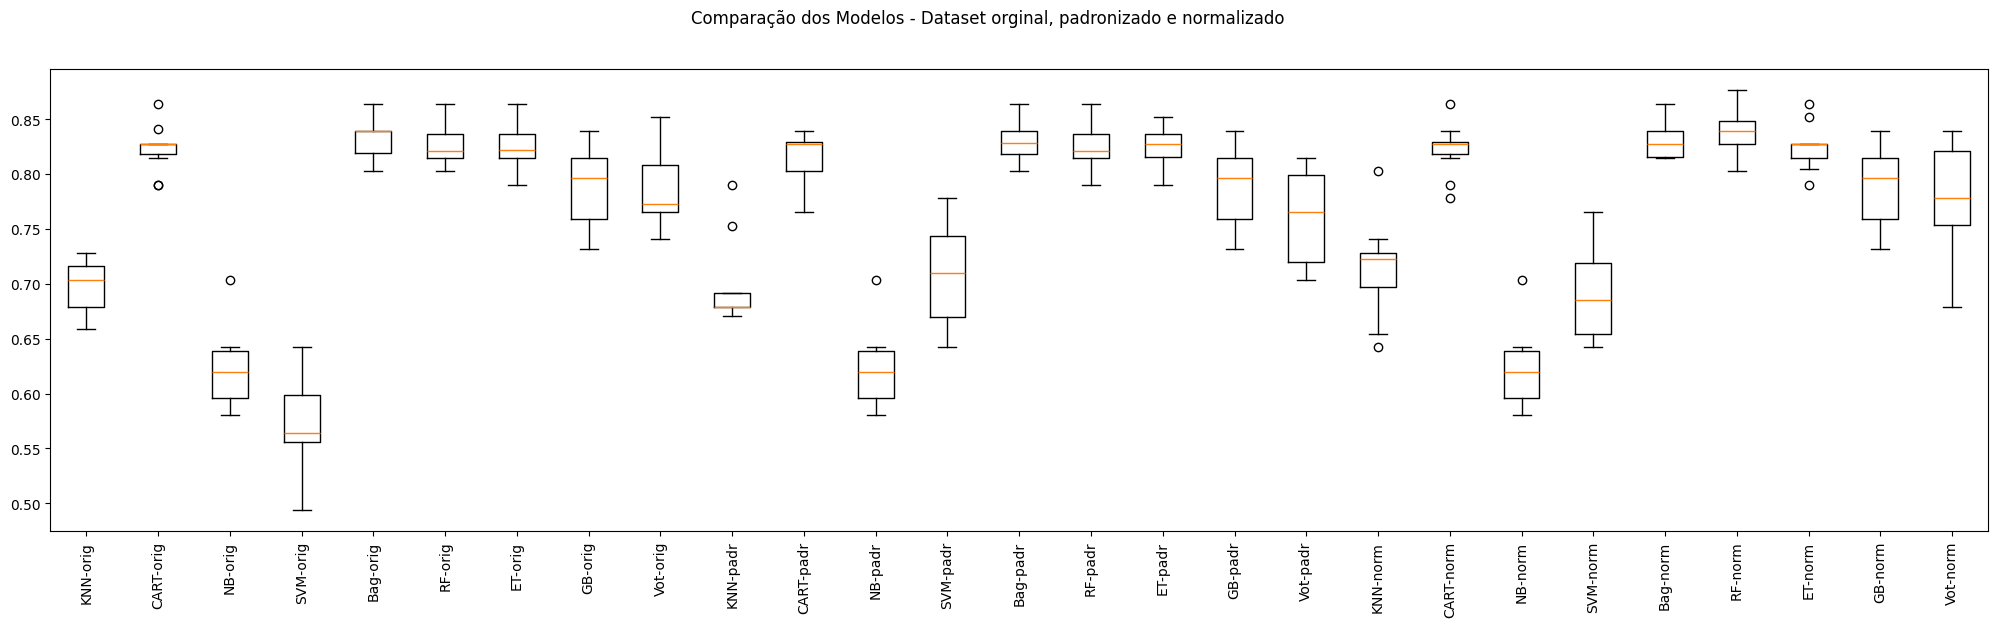

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset Original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos Hiperparâmetros

Este código ajusta os hiperparâmetros do classificador Random Forest usando `RandomizedSearchCV`. Ele avalia combinações de hiperparâmetros, como o número de estimadores (`n_estimators`), a profundidade máxima das árvores (`max_depth`), o número mínimo de amostras para dividir um nó (`min_samples_split`) e o número mínimo de amostras em cada folha (`min_samples_leaf`). A busca é realizada em um pipeline que utiliza o dataset original, e o melhor score e configuração são exibidos após a execução.

In [ ]:
np.random.seed(7)

# Configurando os hiperparâmetros para RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50, 100, 150],  # Número de árvores
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima
    'min_samples_split': [2, 5, 10],  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Mínimo de amostras em cada folha
    'bootstrap': [True, False],  # Método de amostragem
}

# Configurando RandomizedSearchCV
rf = RandomForestClassifier(random_state=7)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,  # Número de combinações aleatórias a testar
    scoring=scoring,
    cv=kfold,
    random_state=7,
    n_jobs=-1  # Paralelização para acelerar o processo
)

# Executa a busca
random_search.fit(X_train, y_train)

# Melhor resultado
print("Melhor pontuação: %f usando %s" % (random_search.best_score_, random_search.best_params_))

Melhor pontuação: 0.831105 usando {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


## **Finalização do Modelo**

### Descrição

#### Seleção das Métricas de Avaliação

A métrica escolhida para avaliar o desempenho foi a acurácia, que é adequada para problemas de classificação em que as classes estão balanceadas. A acurácia reflete a proporção de previsões corretas e fornece uma visão clara do desempenho do modelo em dados não vistos.

---

#### Treinamento e Teste do Modelo Final

O modelo final selecionado foi treinado com o dataset completo para maximizar o aprendizado dos padrões nos dados. Em seguida, ele foi testado em novos dados, onde a acurácia foi usada para verificar o desempenho final.

---



### Avaliação Final do Modelo no Conjunto de Teste

Este código utiliza os melhores hiperparâmetros encontrados durante a otimização para configurar o modelo Random Forest. Os dados de treino são padronizados com o `StandardScaler`, e o mesmo escalador é aplicado ao conjunto de teste para garantir consistência. O modelo é treinado com os dados padronizados de treino e, em seguida, avaliado no conjunto de teste. Por fim, a acurácia do modelo é calculada e exibida, representando o desempenho final.

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Aplicando os melhores hiperparâmetros encontrados
best_params = random_search.best_params_  # Obtém os melhores parâmetros
model = RandomForestClassifier(**best_params, random_state=7)  # Aplica os parâmetros no modelo

# Preparação do scaler com o conjunto de treino
scaler = StandardScaler().fit(X_train)  # Ajuste do scaler
rescaledX = scaler.transform(X_train)  # Padronização no conjunto de treino

# Treinamento do modelo
model.fit(rescaledX, y_train)

# Avaliação do modelo no conjunto de teste
rescaledTestX = scaler.transform(X_test)  # Padronização no conjunto de teste
predictions = model.predict(rescaledTestX)

# Métrica de avaliação
print(accuracy_score(y_test, predictions))

0.8472906403940886


### Treinamento Final do Modelo com Todo o Dataset

Este código padroniza todo o dataset e treina o modelo final de uma Random Forest  nos dados completos, maximizando o aprendizado para a implementação final.

In [ ]:
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=50,
                       random_state=7)

### Simulando a Aplicação do Modelo em Dados não Vistos

Este código cria um DataFrame com novos dados de entrada e aplica o mesmo `StandardScaler` usado no dataset de treino para padronizá-los. Isso garante que os novos dados estejam na mesma escala dos dados de treinamento, permitindo que o modelo faça previsões de forma consistente.

In [ ]:
# Criando DataFrame com os valores selecionados
data = {
    'Age': [15, 23, 25],
    'SystolicBP': [120, 130, 130],
    'DiastolicBP': [60, 70, 80],
    'BS': [6.1, 7.01, 10.0],
    'BodyTemp': [98.0, 98.0, 98.0],
    'HeartRate': [76, 78, 86]
}

entrada = pd.DataFrame(data)

# Padronizando a entrada usando o scaler utilizado em X
X_entrada = entrada.values.astype(float)
rescaledEntradaX = scaler.transform(X_entrada)

print(rescaledEntradaX)

[[-1.10425321  0.36976548 -1.18600873 -0.79770964 -0.4852155   0.21005383]
 [-0.51024114  0.91339632 -0.46549297 -0.52127416 -0.4852155   0.45743429]
 [-0.36173812  0.91339632  0.25502279  0.38701388 -0.4852155   1.44695615]]


### Predição de Classes dos Novos Dados

Este código utiliza o modelo treinado para prever as classes dos novos dados padronizados e exibe as previsões.

In [ ]:
# Predição de classes para esses novos dados
saidas = model.predict(rescaledEntradaX)
print(saidas)

['low risk' 'mid risk' 'high risk']


## **Análise de Resultado**

### Coerência dos Resultados

Os resultados observados na base de teste fazem sentido, indicando que o modelo é capaz de generalizar para dados não vistos. Não foram observados problemas significativos de inconsistência nos resultados.

---



### Análise de Overfitting

A avaliação com validação cruzada e o desempenho na base de teste indicam que o modelo não sofreu de overfitting. O uso de validação cruzada permitiu verificar a estabilidade dos resultados em diferentes partições dos dados, reduzindo o risco de overfitting.

---



## **Conclusão**

Na comparação entre os modelos testados, DecisionTreeClassifier, BaggingClassifier e RandomForestClassifier, apresentaram desempenho satisfatório, com alta acurácia. O DecisionTreeClassifier se destacou por sua baixa variabilidade, entregando resultados consistentes devido à simplicidade de sua estrutura. No entanto, seu desempenho ficou ligeiramente abaixo dos modelos de ensembles, que conseguem capturar melhor padrões complexos ao combinar múltiplas previsões. Entre os modelos de ensembles, o BaggingClassifier demonstrou bom equilíbrio entre acurácia e estabilidade, mas foi o RandomForestClassifier que se sobressaiu, alcançando a maior acurácia dentre os modelos avaliados.

A escolha do RandomForestClassifier como a melhor solução se justifica pela combinação de alta precisão e robustez. Esse modelo, por agregar várias árvores de decisão e realizar uma votação para determinar a classificação final, minimiza o impacto de possíveis variações nas previsões individuais, proporcionando uma excelente capacidade de generalização. Essa característica é fundamental, pois aumenta a confiabilidade do modelo em dados não vistos, tornando-o uma solução superior ao balancear variabilidade e desempenho. Portanto, o RandomForestClassifier foi escolhido por seu desempenho consistente, alta acurácia, sendo a melhor opção para resolver o problema proposto.